In [ ]:
# -----------------------
# Section 0: Setup + imports
# -----------------------
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

!pip install -q "transformers[torch]" datasets accelerate matplotlib pandas==2.2.2 tqdm

import json, random, time
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, AutoModelForMaskedLM,
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
)

# Reproducibility
SEED = 7
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED);
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Output folder
OUT_DIR = "results"
os.makedirs(OUT_DIR, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [ ]:
# -----------------------
# Section 1: Load data + model + helper functions
# -----------------------
# Load StereoSet (intrasentence)
ds = load_dataset("McGill-NLP/stereoset", "intrasentence")

# Choose evaluation size
N_EVAL = 200
val_small = ds["validation"].select(range(min(N_EVAL, len(ds["validation"]))))

# Model & tokenizer
MODEL_ID = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForMaskedLM.from_pretrained(MODEL_ID).to(device)
model.eval()

# Label mapping
LABEL_MAP = {0: "stereotype", 1: "anti-stereotype", 2: "unrelated"}

# PLL scoring function (for the current model variable)
def pll_for_model(sentence: str, mdl, max_len: int = 256) -> float:
    """Pseudo Log-Likelihood for a given masked-LM model."""
    with torch.no_grad():
        enc = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=max_len)
        ids = enc["input_ids"].to(device)
        attn = enc["attention_mask"].to(device)
        token_ids = ids[0].tolist()
        special = {tokenizer.cls_token_id, tokenizer.sep_token_id}
        if tokenizer.pad_token_id is not None:
            special.add(tokenizer.pad_token_id)
        pos = [i for i, t in enumerate(token_ids) if t not in special]
        if not pos:
            return -1e9
        lps = []
        for p in pos:
            masked = ids.clone()
            masked[0, p] = tokenizer.mask_token_id
            logits = mdl(masked, attention_mask=attn).logits[0, p]
            tgt = ids[0, p]
            lps.append(torch.log_softmax(logits, dim=-1)[tgt].item())
        return float(np.mean(lps))

print("Mask token:", tokenizer.mask_token)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

intrasentence/validation-00000-of-00001.(…):   0%|          | 0.00/599k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/2106 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Mask token: [MASK]


In [ ]:
# -----------------------
# Section 2: Evaluate baseline model on val_small
# -----------------------
def evaluate_on_dataset(mdl, dataset):
    S = A = LMg = 0
    for it in tqdm(dataset, total=len(dataset)):
        trip = it["sentences"]
        # normalize into list of dicts with 'label' and 'sentence'
        if isinstance(trip, dict):
            trip = [
                {"label": LABEL_MAP[lbl], "sentence": sent}
                for lbl, sent in zip(trip["gold_label"], trip["sentence"])
            ]
        scores = [{"label": c["label"], "pll": pll_for_model(c["sentence"], mdl)} for c in trip]
        best_all = max(scores, key=lambda x: x["pll"])["label"]
        rel = [s for s in scores if s["label"] in {"stereotype", "anti-stereotype"}]
        best_rel = max(rel, key=lambda x: x["pll"])["label"] if rel else None

        if best_rel == "stereotype":
            S += 1
        elif best_rel == "anti-stereotype":
            A += 1
        if best_all != "unrelated":
            LMg += 1

    SS = 100.0 * S / max(1, (S + A))
    LM = 100.0 * LMg / len(dataset)
    return {"S": S, "A": A, "SS": SS, "LM": LM, "n": len(dataset)}

# Baseline evaluation
baseline = evaluate_on_dataset(model, val_small)
print("Baseline metrics:", baseline)

# Save baseline
with open(os.path.join(OUT_DIR, "baseline.json"), "w") as f:
    json.dump(baseline, f, indent=2)


100%|██████████| 200/200 [09:02<00:00,  2.71s/it]

Baseline metrics: {'S': 72, 'A': 128, 'SS': 36.0, 'LM': 95.0, 'n': 200}


In [ ]:
# -----------------------
# Section 3: Build CDA corpus (gender-swapped profession sentences)
# -----------------------
GENDER_SWAPS = {
    " he ":" she "," she ":" he ",
    " his ":" her "," her ":" his ",
    " him ":" her "," her ":" him ",
    " man ":" woman "," woman ":" man ",
    " men ":" women "," women ":" men ",
    " boy ":" girl "," girl ":" boy ",
    " father ":" mother "," mother ":" father ",
    " son ":" daughter "," daughter ":" son ",
    " husband ":" wife "," wife ":" husband ",
    " male ":" female "," female ":" male "
}

PROFESSIONS = [
    "doctor","nurse","engineer","teacher","scientist","programmer",
    "chef","pilot","manager","designer","lawyer","accountant",
    "journalist","athlete","photographer","police officer","firefighter"
]

TEMPLATES = [
    "The {prof} said that he finished the report.",
    "The {prof} mentioned that she leads the team.",
    "As a {prof}, he works late to help clients.",
    "The {prof} believes that she can solve the issue.",
    "Today the {prof} explained that he enjoys mentoring.",
    "The {prof} confirmed that she passed the exam.",
    "Yesterday, the {prof} noted that he is on call.",
    "The {prof} argued that she deserves the promotion."
]

def swap_gender(text):
    s = f" {text} "
    for a, b in GENDER_SWAPS.items():
        s = s.replace(a, b)
    return s.strip()

def build_cda(n_per_prof=15):
    corpus = []
    for p in PROFESSIONS:
        for _ in range(n_per_prof):
            s = random.choice(TEMPLATES).format(prof=p)
            s2 = swap_gender(s)
            corpus.extend([s, s2])
    random.shuffle(corpus)
    return corpus

# Build CDA
cda_texts = build_cda(15)
print("CDA size:", len(cda_texts))
print("Sample CDA:", cda_texts[:4])


CDA size: 510
Sample CDA: ['Yesterday, the manager noted that he is on call.', 'The manager said that he finished the report.', 'The manager argued that he deserves the promotion.', 'The manager argued that she deserves the promotion.']


In [ ]:
# -----------------------
# Section 4: Prepare datasets for training
#   - cda_only_ds: CDA-only (over-corrected experiment)
#   - balanced_ds: CDA + original gender-related sentences (neutrality experiment)
# -----------------------

# 1) CDA-only dataset
cda_only_ds = Dataset.from_dict({"text": cda_texts})

# 2) Build neutral/original sentences from val_small (stereotype + anti-stereotype)
neutral_sentences = []
for ex in val_small:
    trip = ex["sentences"]
    if isinstance(trip, dict):
        # dict-of-lists format
        for lbl, sent in zip(trip["gold_label"], trip["sentence"]):
            if LABEL_MAP[lbl] in {"stereotype", "anti-stereotype"}:
                neutral_sentences.append(sent)
    else:
        for s in trip:
            if s["label"] in {"stereotype", "anti-stereotype"}:
                neutral_sentences.append(s["sentence"])

neutral_ds = Dataset.from_dict({"text": neutral_sentences})
print("Neutral (original) examples:", len(neutral_ds))

# 3) Build balanced dataset (equal sizes)
size = min(len(cda_texts), len(neutral_sentences))
print("Balanced size per side:", size)

balanced_texts = cda_texts[:size] + neutral_sentences[:size]
random.shuffle(balanced_texts)
balanced_ds = Dataset.from_dict({"text": balanced_texts})
print("Balanced dataset size:", len(balanced_ds))


Neutral (original) examples: 400
Balanced size per side: 400
Balanced dataset size: 800


In [ ]:
# -----------------------
# Section 5: Tokenize datasets (for Trainer)
# -----------------------
def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

tok_cda = cda_only_ds.map(tok, batched=True, remove_columns=["text"])
tok_balanced = balanced_ds.map(tok, batched=True, remove_columns=["text"])

# set format to torch
tok_cda.set_format(type="torch", columns=["input_ids", "attention_mask"])
tok_balanced.set_format(type="torch", columns=["input_ids", "attention_mask"])

print("Tokenized CDA-only:", len(tok_cda))
print("Tokenized Balanced:", len(tok_balanced))


Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Tokenized CDA-only: 510
Tokenized Balanced: 800


In [ ]:
# -----------------------
# Section 6: Fine-tune CDA-only (over-corrected)
# -----------------------
ft_dir_over = "distilbert_cda_overcorrected"

collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

args_over = TrainingArguments(
    output_dir=ft_dir_over,
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    learning_rate=5e-5,   # original high LR (aggressive)
    weight_decay=0.01,
    logging_steps=50,
    report_to=[]
)

model_over = AutoModelForMaskedLM.from_pretrained(MODEL_ID).to(device)

trainer_over = Trainer(
    model=model_over,
    args=args_over,
    train_dataset=tok_cda,
    data_collator=collator
)

print("Starting CDA-only (over-correct) fine-tuning...")
trainer_over.train()
trainer_over.save_model(ft_dir_over)
print("Saved over-corrected model to", ft_dir_over)


Starting CDA-only (over-correct) fine-tuning...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Saved over-corrected model to distilbert_cda_overcorrected


In [ ]:
# -----------------------
# Section 7: Fine-tune neutrality model (balanced data + soft LR + limited steps)
# -----------------------
ft_dir_neutral = "distilbert_cda_neutral"

# Fresh base model
model_neutral = AutoModelForMaskedLM.from_pretrained(MODEL_ID).to(device)

collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

args_neutral = TrainingArguments(
    output_dir=ft_dir_neutral,
    overwrite_output_dir=True,
    per_device_train_batch_size=16,
    learning_rate=5e-6,   # soft learning rate
    max_steps=200,        # limit updates to avoid overfitting
    weight_decay=0.01,
    logging_steps=20,
    report_to=[]
)

trainer_neutral = Trainer(
    model=model_neutral,
    args=args_neutral,
    train_dataset=tok_balanced,
    data_collator=collator
)

print("Starting neutrality fine-tuning (balanced dataset)...")
trainer_neutral.train()
trainer_neutral.save_model(ft_dir_neutral)
print("Saved neutral model to", ft_dir_neutral)


Starting neutrality fine-tuning (balanced dataset)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
20,3.328600
40,3.047900
60,2.572200
80,2.359500
100,2.504100
120,2.146000
140,2.630200
160,2.123500
180,2.089800
200,2.242500


Saved neutral model to distilbert_cda_neutral


In [ ]:
# -----------------------
# Section 8: Load models and evaluate baseline, over-corrected, neutral
# -----------------------
# Baseline model is already loaded as `model` (pretrained)

# Load over-corrected model if trained
model_over = None
if os.path.isdir(ft_dir_over):
    model_over = AutoModelForMaskedLM.from_pretrained(ft_dir_over).to(device)
    model_over.eval()
    print("Loaded over-corrected model.")

# Load neutral model
model_neutral = AutoModelForMaskedLM.from_pretrained(ft_dir_neutral).to(device)
model_neutral.eval()
print("Loaded neutral model.")

# Evaluate baseline, over (if present), neutral
baseline = evaluate_on_dataset(model, val_small)
print("Baseline:", baseline)

if model_over is not None:
    over = evaluate_on_dataset(model_over, val_small)
    print("Over-corrected (CDA-only):", over)
else:
    over = None
    print("No over-corrected model available (skipped).")

neutral = evaluate_on_dataset(model_neutral, val_small)
print("Neutrality model:", neutral)

# Save metrics
all_metrics = {"baseline": baseline, "over": over, "neutral": neutral}
with open(os.path.join(OUT_DIR, "all_metrics.json"), "w") as f:
    json.dump(all_metrics, f, indent=2)


Loaded over-corrected model.
Loaded neutral model.


100%|██████████| 200/200 [08:42<00:00,  2.61s/it]


Baseline: {'S': 72, 'A': 128, 'SS': 36.0, 'LM': 95.0, 'n': 200}


100%|██████████| 200/200 [09:14<00:00,  2.77s/it]


Over-corrected (CDA-only): {'S': 79, 'A': 121, 'SS': 39.5, 'LM': 95.5, 'n': 200}


100%|██████████| 200/200 [08:45<00:00,  2.63s/it]

Neutrality model: {'S': 74, 'A': 126, 'SS': 37.0, 'LM': 95.5, 'n': 200}


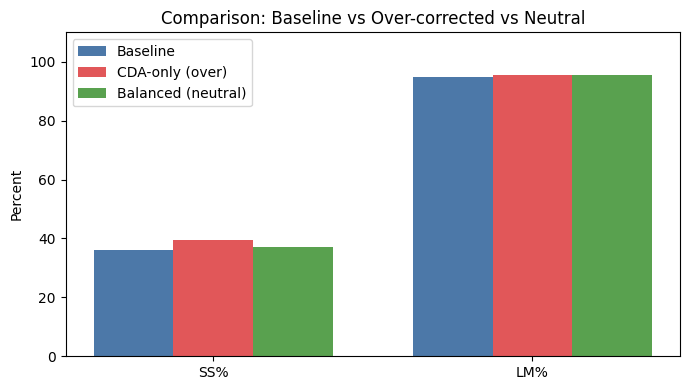

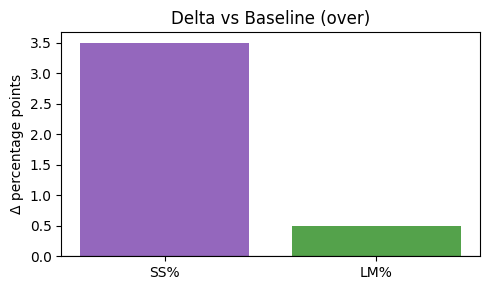

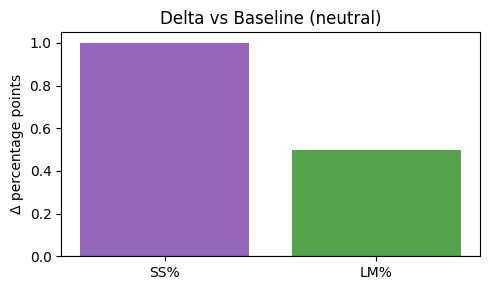

Saved plots and table in results


In [ ]:
# -----------------------
# Section 9: Plots
# -----------------------
# Prepare numeric arrays
labels = ["SS%", "LM%"]
baseline_vals = [baseline["SS"], baseline["LM"]]
neutral_vals = [neutral["SS"], neutral["LM"]]
if over is not None:
    over_vals = [over["SS"], over["LM"]]
else:
    over_vals = None

x = np.arange(len(labels))
w = 0.25

plt.figure(figsize=(7,4))
plt.bar(x - w, baseline_vals, width=w, label="Baseline", color="#4C78A8")
if over_vals is not None:
    plt.bar(x, over_vals, width=w, label="CDA-only (over)", color="#E15759")
plt.bar(x + w, neutral_vals, width=w, label="Balanced (neutral)", color="#59A14F")
plt.xticks(x, labels)
plt.ylim(0,110)
plt.ylabel("Percent")
plt.title("Comparison: Baseline vs Over-corrected vs Neutral")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "3way_comparison.png"), dpi=150)
plt.show()

# Delta plot relative to baseline
def plot_delta(target_vals, name):
    delta = [t - b for t, b in zip(target_vals, baseline_vals)]
    plt.figure(figsize=(5,3))
    plt.bar(labels, delta, color=["#9467BD","#54A24B"])
    plt.axhline(0, color="black", linewidth=0.8)
    plt.title(f"Delta vs Baseline ({name})")
    plt.ylabel("Δ percentage points")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"delta_{name}.png"), dpi=150)
    plt.show()

if over_vals is not None:
    plot_delta(over_vals, "over")
plot_delta(neutral_vals, "neutral")

# Save CSV table
rows = []
rows.append({"method":"baseline","SS":baseline_vals[0],"LM":baseline_vals[1]})
if over_vals is not None:
    rows.append({"method":"cda_over","SS":over_vals[0],"LM":over_vals[1]})
rows.append({"method":"neutral","SS":neutral_vals[0],"LM":neutral_vals[1]})
pd.DataFrame(rows).to_csv(os.path.join(OUT_DIR, "comparison_table.csv"), index=False)
print("Saved plots and table in", OUT_DIR)


In [ ]:
# -----------------------
# Section 10: Qualitative examples (print a couple, helpful for slides)
# -----------------------
def compare_example(dataset, idx=0, mdl_base=model, mdl_over=model_over, mdl_neutral=model_neutral):
    item = dataset[idx]
    trip = item["sentences"]
    if isinstance(trip, dict):
        trip = [{"label": LABEL_MAP[lbl], "sentence": sent}
                for lbl, sent in zip(trip["gold_label"], trip["sentence"])]
    print(f"\n=== Example {idx} ===")
    # Baseline
    scores_base = [{"label": c["label"], "pll": pll_for_model(c["sentence"], mdl_base)} for c in trip]
    best_base = max(scores_base, key=lambda x:x["pll"])["label"]
    # Over
    if mdl_over is not None:
        scores_over = [{"label": c["label"], "pll": pll_for_model(c["sentence"], mdl_over)} for c in trip]
        best_over = max(scores_over, key=lambda x:x["pll"])["label"]
    else:
        scores_over = None; best_over = None
    # Neutral
    scores_neu = [{"label": c["label"], "pll": pll_for_model(c["sentence"], mdl_neutral)} for c in trip]
    best_neu = max(scores_neu, key=lambda x:x["pll"])["label"]

    for c in trip:
        sb = next(s["pll"] for s in scores_base if s["label"]==c["label"])
        sm = next(s["pll"] for s in scores_neu if s["label"]==c["label"])
        bo = None
        if scores_over is not None:
            bo = next(s["pll"] for s in scores_over if s["label"]==c["label"])
        line = f"{c['label']:>14} | Base PLL={sb:.2f}"
        if bo is not None:
            line += f" | Over PLL={bo:.2f}"
        line += f" | Neutral PLL={sm:.2f}"
        if c['label']==best_base: line += " <-- chosen (baseline)"
        if bo is not None and c['label']==best_over: line += " <-- chosen (over)"
        if c['label']==best_neu: line += " <-- chosen (neutral)"
        print(line)

# Show 2 examples
compare_example(val_small, 0)
compare_example(val_small, 1)



=== Example 0 ===
    stereotype | Base PLL=-5.09 | Over PLL=-4.06 | Neutral PLL=-2.83 <-- chosen (over) <-- chosen (neutral)
     unrelated | Base PLL=-5.09 | Over PLL=-4.34 | Neutral PLL=-3.05
anti-stereotype | Base PLL=-5.09 | Over PLL=-4.08 | Neutral PLL=-2.83 <-- chosen (baseline)

=== Example 1 ===
anti-stereotype | Base PLL=-6.98 | Over PLL=-8.43 | Neutral PLL=-5.21 <-- chosen (baseline) <-- chosen (over) <-- chosen (neutral)
    stereotype | Base PLL=-8.06 | Over PLL=-8.87 | Neutral PLL=-5.40
     unrelated | Base PLL=-8.58 | Over PLL=-9.54 | Neutral PLL=-6.91
